Take a look at this notebook: https://github.com/kaiden-ong/IsraelPalestineSentimentAnalysis/blob/main/Cleaning%20%26%20Analysis/MachineLearningModels.ipynb

In these tests, fake = 0 and real = 1

In [1]:
import matplotlib.pyplot as plt
import csv
import sklearn
import numpy as np
import pandas as pd
from textblob import TextBlob
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import joblib

In [2]:
import pkg_resources

textblob_version = pkg_resources.get_distribution("nltk").version
print(textblob_version)

3.9.1


In [3]:
df = pd.read_csv("../data/WELFake_Dataset.csv")
df['text'] = df['title'] + " " + df['text']
df = df.drop(columns=['title', 'Unnamed: 0'])
df = df.dropna()
df.head()

,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",0
4,SATAN 2: Russia unvelis an image of its terrif...,1
5,About Time! Christian Group Sues Amazon and SP...,1


In [4]:
df.describe()

,label
count,71537.000000
mean,0.510351
std,0.499896
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [6]:
df_test = pd.read_csv("../data/FakeNewsNet.csv")
df_test = df_test.drop(columns=['news_url', 'tweet_num', 'source_domain'])
df_test = df_test.dropna()
df_test.head()

,title,real
0,Kandi Burruss Explodes Over Rape Accusation on...,1
1,People's Choice Awards 2018: The best red carp...,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,1
3,Colombian singer Maluma sparks rumours of inap...,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,1


In [7]:
df_test.describe()

,real
count,23196.000000
mean,0.751897
std,0.431921
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [8]:
X = df['text']
y = df['label']

In [9]:
df_sample = df.sample(n=10000, random_state=42)

In [10]:
X = df_sample['text']
y = df_sample['label']

In [11]:
nltk.download('punkt')

def split_into_lemmas(content):
    # Convert to lowercase
    content = content.lower()
    # Tokenize and lemmatize
    words = TextBlob(content).words
    return ' '.join([word.lemmatize() for word in words])

# Assuming X is your DataFrame column with text data
X.apply(split_into_lemmas)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrpi3\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


54359    live at truthdig robert scheer and thomas fran...
6993     the mirage of a return to manufacturing greatn...
28912    british pm expected to offer to fill post-brex...
65965    checkmating obama originally published by the ...
2307     thirty-eight injured in police charge in catal...
                               ...                        
3767     why do we hear more about hillary 's email tha...
59222    moldova pm confident of securing eu funding in...
28313    comment on the creative gift of adhd disorder ...
57294    deep fried offshore tj mott i 've been a devel...
40514    obama regime grant early release to terrorist ...
Name: text, Length: 10000, dtype: object

In [12]:

count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(X)

# Create a TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_count)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

SVM

In [39]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),  # <== change here
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(n_splits=5),  # what type of cross validation to use
)

In [40]:
svm_detector = grid_svm.fit(X_train, y_train)
# Evaluate the model
print('Confusion Matrix : \n')
print(confusion_matrix(y_test, svm_detector.predict(X_test)))
print(classification_report(y_test, svm_detector.predict(X_test)))

Confusion Matrix : 

[[869 108]
 [183 840]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       977
           1       0.89      0.82      0.85      1023

    accuracy                           0.85      2000
   macro avg       0.86      0.86      0.85      2000
weighted avg       0.86      0.85      0.85      2000



In [16]:
X_test_sample = df_test['title']
y_test_sample = df_test['real']

# Apply the same preprocessing (lemmatization)
X_test_processed = X_test_sample.apply(split_into_lemmas)

y_pred_test = svm_detector.predict(X_test_processed)

# Evaluate the model on the test data
print('Confusion Matrix on Test Data:\n')
print(confusion_matrix(y_test_sample, y_pred_test))
print('Classification Report on Test Data:\n')
print(classification_report(y_test_sample, y_pred_test))

# Optionally, print accuracy score
print('Accuracy Score on Test Data:', accuracy_score(y_test_sample, y_pred_test))

Confusion Matrix on Test Data:

[[ 2037  3718]
 [ 6559 10882]]
Classification Report on Test Data:

              precision    recall  f1-score   support

           0       0.24      0.35      0.28      5755
           1       0.75      0.62      0.68     17441

    accuracy                           0.56     23196
   macro avg       0.49      0.49      0.48     23196
weighted avg       0.62      0.56      0.58     23196

Accuracy Score on Test Data: 0.5569494740472495


In [18]:
import pickle
with open('../models/svm_10000.pkl', 'wb') as f:
    pickle.dump(svm_detector, f)

NB

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [20]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB().fit(X_train, y_train)


[0 0 1 ... 0 1 0]
accuracy 0.89575
confusion matrix
 [[3622  359]
 [ 475 3544]]
(row=expected, col=predicted)


Text(0.5, 0, 'predicted label')

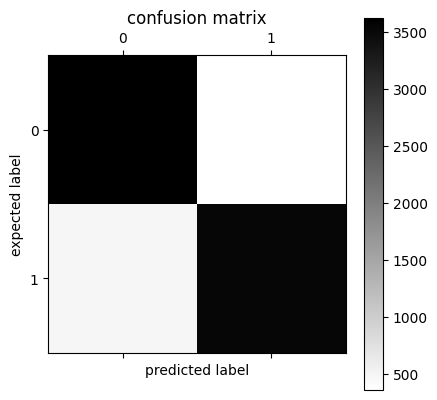

In [22]:
train_predictions = naive_bayes.predict(X_train)

print (train_predictions)
print ('accuracy', accuracy_score(y_train, train_predictions))
print ('confusion matrix\n', confusion_matrix(y_train, train_predictions))
print ('(row=expected, col=predicted)')

plt.matshow(confusion_matrix(y_train, train_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [33]:
X_test_sample = df_test['title']
y_test_sample = df_test['real']

# Apply the same preprocessing (lemmatization)
X_test_processed = X_test_sample.apply(split_into_lemmas)
X_test_count = count_vectorizer.transform(X_test_processed)
X_test_tfidf = tfidf_transformer.transform(X_test_count)

y_pred_test = naive_bayes.predict(X_test_tfidf)

# Evaluate the model on the test data
print('Confusion Matrix on Test Data:\n')
print(confusion_matrix(y_test_sample, y_pred_test))
print('Classification Report on Test Data:\n')
print(classification_report(y_test_sample, y_pred_test))

# Optionally, print accuracy score
print('Accuracy Score on Test Data:', accuracy_score(y_test_sample, y_pred_test))

Confusion Matrix on Test Data:

[[ 1271  4484]
 [ 4284 13157]]
Classification Report on Test Data:

              precision    recall  f1-score   support

           0       0.23      0.22      0.22      5755
           1       0.75      0.75      0.75     17441

    accuracy                           0.62     23196
   macro avg       0.49      0.49      0.49     23196
weighted avg       0.62      0.62      0.62     23196

Accuracy Score on Test Data: 0.6220037937575444


In [34]:
import pickle
with open('../models/nb_10000.pkl', 'wb') as f:
    pickle.dump(naive_bayes, f)

RF

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [62]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(max_depth=45, random_state=42, class_weight='balanced').fit(X_train, y_train)

[0 0 1 ... 0 1 0]
accuracy 0.89575
confusion matrix
 [[3622  359]
 [ 475 3544]]
(row=expected, col=predicted)


Text(0.5, 0, 'predicted label')

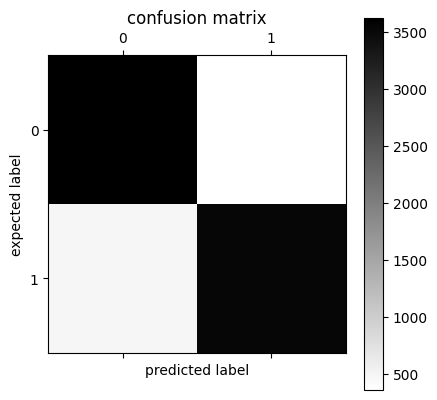

In [63]:
y_pred_test = random_forest.predict(X_train)

print (train_predictions)
print ('accuracy', accuracy_score(y_train, train_predictions))
print ('confusion matrix\n', confusion_matrix(y_train, train_predictions))
print ('(row=expected, col=predicted)')

plt.matshow(confusion_matrix(y_train, train_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [ ]:
import pickle
with open('../models/rf_10000.pkl', 'wb') as f:
    pickle.dump(random_forest, f)